# <center> Временные ряды
## <center> неделя 7
<center> Глазунов А.В.

Основной задачей данной недели является построение финального решения на основе наработок предыдущих недель. Ясно, что много из приведенного ниже можно существенно улучшить и ускорить, при этом параметры и признаки можно подобрать более тщательно, но в данном проекте я придерживаюсь жадного алгоритма надстроек на основе предыдущего опыта, при этом основная задача финальной части проекта - построение прототипа решения регрессионной задачи.

Подготовим директории и библиотеки

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/'My Drive'/Colab_Notebooks/ML_c6_TAXI

/content/gdrive/My Drive/Colab_Notebooks/ML_c6_TAXI


In [3]:
PATH_TO_DATA = 'data'

In [4]:
pip install category_encoders

In [5]:
import warnings
warnings.filterwarnings('ignore')


from sklearn.base import BaseEstimator, TransformerMixin

from category_encoders import LeaveOneOutEncoder,TargetEncoder, BinaryEncoder,SumEncoder,BackwardDifferenceEncoder,HelmertEncoder
import os
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import gc
import xgboost as xgb
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import itertools
from sklearn import model_selection, metrics, pipeline, preprocessing,impute
from sklearn.metrics import mean_absolute_error as mae
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression,f_regression

from sklearn.preprocessing import PowerTransformer
from dateutil.relativedelta import relativedelta

Иницилизируем необходимые функции

In [6]:
def harmonic_feats(data,kw=2,ky=0,linear_fe=False):
    #Гармонические признаки и тренды

    df = data.copy()
    zones_number = df.zone_id.unique().shape[0]
    arg = df.hour_counter.unique()
    fe_list = []
    columns = []

    #Линейный признак для описания простейшего тренда
    if linear_fe:
      fe_list.append(arg) 
      columns.append('t')

    #Признаки для описания недельной сезонности
    for i in range(1,kw+1):
      fe_list.append(np.sin(arg*2*np.pi*i/168))
      columns.append(f'sin(2*pi*t*{i}/168)')
      fe_list.append(np.cos(arg*2*np.pi*i/168))
      columns.append(f'cos(2*pi*t*{i}/168)')
  
    #Признаки для описания годовой сезонности
    for j in range(1,ky+1):
      fe_list.append(np.sin(arg*2*np.pi*j/8766))
      columns.append(f'sin(2*pi*t*{j}/8766)')
      fe_list.append(np.cos(arg*2*np.pi*i/8766))
      columns.append(f'cos(2*pi*t*{j}/8766)')

    df = pd.DataFrame(fe_list).T
    df.columns = columns

    df_list = []
    for i in range(zones_number):
      df_list.append(df)

    return pd.concat(df_list,ignore_index=True)

In [7]:
def find_mean_to_fill_empty(data):
  #Средние значения рядов по зонам для заполнения пропусков

  data = data.copy()
  ts_mean_values = {}
  for zone in tqdm_notebook(data.zone_id.unique()):
    data_zone = data[data['zone_id']==zone]
    ts_zone_means = []
    for day in range(7):
      for hour in range(0,24):     
        ts_mean_day_hour_value = data_zone[data_zone['day_of_week']==day][data_zone['day_hour']==hour]['ts'].mean()
        ts_zone_means.append(ts_mean_day_hour_value) 

    ts_mean_values[zone] = ts_zone_means
  return ts_mean_values

In [8]:
def autoreg_feats(data,k,kd,fill_empty=False,ts_mean_values=None):
  #Авторегрессионные признаки

  df = data.copy()
  zone_list = df.zone_id.unique()
  #Цикл по зонам, запись в список
  zone_arfeats_list = []   
  for zone in zone_list:
    df_zone = df[df.zone_id==zone].copy()    
    df_zone.index = list(range(df_zone.shape[0]))
    ts_zone = df_zone.ts.values
        
    #Подготовка авторегрессионных признаков при смещении на 1..k часов назад
    feats_shift_hour = np.zeros((df_zone.shape[0],k))
    for i in range(df_zone.shape[0]):
      for j in range(k):
        shift = j+1
        if shift <= i:
          feats_shift_hour[i,j] = ts_zone[i-shift]
        elif fill_empty:#Заполнение недостающих значений средними
          shift = shift % 168
          means = ts_mean_values[zone]
          day = df_zone.day_of_week[i]
          hour = df_zone.day_hour[i]     
          
          feats_shift_hour[i,j] = means[24*day + hour - shift]

    df_arfeats1 = pd.DataFrame(feats_shift_hour)
    df_arfeats1.columns = [f'ts_shift_{i}_hours' for i in range(1,k+1)]

    #Подготовка авторегрессионных признаков при смещении на 1..kd дней назад
    feats_shift_day = np.zeros((df_zone.shape[0],kd))
    
    for i in range(df_zone.shape[0]):
      for j in range(kd):
          shift = 24*(j+1)
          if  shift <= i:
            feats_shift_day[i,j] = ts_zone[i-shift]
          elif fill_empty:#Заполнение недостающих значений средними
            shift = shift % 168
            means = ts_mean_values[zone]
            day = df_zone.day_of_week[i]
            hour = df_zone.day_hour[i]
            feats_shift_day[i,j] = means[24*day + hour - shift]

    df_arfeats2 = pd.DataFrame(feats_shift_day)
    df_arfeats2.columns = [f'ts_shift_{i}_days' for i in range(1,kd+1)]

    df_arfeats_zone = pd.concat([df_arfeats1,df_arfeats2],axis=1)

    zone_arfeats_list.append(df_arfeats_zone) 
 
  return pd.concat(zone_arfeats_list,ignore_index=True)

In [9]:
def normed_fe_interaction(dataset,level=3, max_feats = 10):
  #Создает признаки на основе комбинаций существующих
  data = dataset.copy()
  
  fe_list = []
 
  for comb in list(itertools.combinations(data.columns,level))[:max_feats]:
  
    if level==2:
      a = (data[comb[0]] - data[comb[0]].mean())/data[comb[0]].std()
      b = (data[comb[1]] - data[comb[1]].mean())/data[comb[1]].std()      
      feature = a*b
      feature.name = f'{comb[0]},{comb[1]}_mix'
      
    elif level==3:
      a = (data[comb[0]] - data[comb[0]].mean())/data[comb[0]].std()
      b = (data[comb[1]] - data[comb[1]].mean())/data[comb[1]].std()
      c = (data[comb[2]] - data[comb[2]].mean())/data[comb[2]].std()
      feature = a*b + a*c + b*c
      feature.name = f'{comb[0]},{comb[1]},{comb[2]}_mix'

    elif level==4:
      a = (data[comb[0]] - data[comb[0]].mean())/data[comb[0]].std()
      b = (data[comb[1]] - data[comb[1]].mean())/data[comb[1]].std()
      c = (data[comb[2]] - data[comb[2]].mean())/data[comb[2]].std()
      d = (data[comb[3]] - data[comb[3]].mean())/data[comb[3]].std()
      feature = a*b + a*c + a*d + b*d + b*c + c*d       
      feature.name = f'{comb[0]},{comb[1]},{comb[2]},{comb[3]}_mix'

    elif level==5:
      a = (data[comb[0]] - data[comb[0]].mean())/data[comb[0]].std()
      b = (data[comb[1]] - data[comb[1]].mean())/data[comb[1]].std()
      c = (data[comb[2]] - data[comb[2]].mean())/data[comb[2]].std()
      d = (data[comb[3]] - data[comb[3]].mean())/data[comb[3]].std()
      e = (data[comb[4]] - data[comb[4]].mean())/data[comb[4]].std()
      feature = a*b + a*c + a*d +a*e + b*c + b*d + b*e + c*d + c*e + d*e
      feature.name = f'{comb[0]},{comb[1]},{comb[2]},{comb[3]},{comb[4]}_mix'      

    fe_list.append(pd.DataFrame(feature))
  if fe_list==[]:
    features = pd.DataFrame()
  else:
    features = pd.concat(fe_list,axis=1) 

  return features


def squared_feats(dataset):
  #Создает признаки-квадраты
  data = dataset.copy()
  
  fe_list = []
  for col in data.columns: 
     feature = data[col]*data[col]
     feature.name = f'{col}**2'
     fe_list.append(pd.DataFrame(feature))
  
  if fe_list==[]:
    features = pd.DataFrame()
  else:
    features = pd.concat(fe_list,axis=1) 

  return features 

def cubic_feats(dataset):
  #Создает признаки-кубы
  data = dataset.copy()
  
  fe_list = []
  for col in data.columns: 
     feature = data[col]*data[col]*data[col]
     feature.name = f'{col}**3'
     fe_list.append(pd.DataFrame(feature))
     
  if fe_list==[]:
    features = pd.DataFrame()
  else:
    features = pd.concat(fe_list,axis=1) 

  return features 

In [10]:
def fe_transformer(num_indices,cat_indices,cat_transformer):    
    return pipeline.FeatureUnion(transformer_list =[
    #numeric
    ('numeric_features_processing', pipeline.Pipeline(steps = [
    ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, num_indices]))#,    
    #('scaling',preprocessing.StandardScaler())             
                        ])),
    #categorical
    ('categorical_features_processing', pipeline.Pipeline(steps = [
    ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, cat_indices])),    
    ('cat_transformer', cat_transformer)            
                        ]))       
    ])

In [11]:
class Estimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, transformer,regressor):
        self.transformer = transformer
        self.regressor = regressor

    def fit(self, X, y):
        self.transformer.fit(X,y)
        X_tr = self.transformer.transform(X) 
         
        self.regressor.fit(X_tr,y)
        return self.regressor

    def predict(self, X):
        X_tr = self.transformer.transform(X)        
        return self.regressor.predict(X_tr)

In [12]:
class EstimatorSelectorFromModel(BaseEstimator, TransformerMixin):
    
    def __init__(self, transformer,selecting_estimator,regressor):
        self.transformer = transformer
        self.selecting_estimator = selecting_estimator
        self.regressor = regressor

    def fit(self, X, y):
        self.transformer.fit(X,y)
        X_tr = self.transformer.transform(X)
        
        self.selecting_estimator.fit(X_tr,y)
        self.selecting_model = SelectFromModel(self.selecting_estimator, prefit=True)
        X_new = self.selecting_model.transform(X_tr)
        
        self.regressor.fit(X_new,y)
        return self.regressor

    def predict(self, X):
        X_tr = self.transformer.transform(X)  
        X_new = self.selecting_model.transform(X_tr)
        return self.regressor.predict(X_new)


In [13]:
def error_estimation(data,params_prep,cols_to_mix_feats=[],cols_for_q=[],cols_for_c=[],
                     cat_encoder =TargetEncoder(),
                     train_lims = ['2015-12-01 00:00:00','2016-05-01 00:00:00'],
                     cols_to_drop=[],reg_algo=None,fill_empty=False,ts_mean_values=None,verbose=False,
                     show_fe_importances = False):  
  dataset = data.copy()

  [k1,k2,k3,k4,k5,k6] = params_prep
  warnings.filterwarnings('ignore')
  if verbose:
    print('------------------')
    print(f'Solving with params{[k1,k2,k3,k4,k5,k6]}')
    print('------------------')
  harmonic_fe = harmonic_feats(dataset,kw=k1,ky=k2,linear_fe=False)
  
  autoreg_fe = autoreg_feats(dataset,k = k3 ,kd = k4,fill_empty=fill_empty,ts_mean_values=ts_mean_values)
  
  if verbose:
    print('------------------')
    print('creation harmonic_fe, autoreg_fe completed')
    print('------------------')

  dataset_mid = pd.concat([dataset,harmonic_fe,autoreg_fe],axis=1)
  

  
  mixed_feats = normed_fe_interaction(dataset_mid[cols_to_mix_feats],level=k5,max_feats = k6)  
  squares = squared_feats(dataset_mid[cols_for_q])
  cubes = cubic_feats(dataset_mid[cols_for_c])
  deriv_feats = pd.concat([squares,cubes,mixed_feats],axis = 1)
  if verbose:
    print('------------------')
    print('creation deriv_feats completed')
    print('------------------')

  dataset_res = pd.concat([dataset_mid,deriv_feats],axis=1).drop(columns=cols_to_drop)
  
  dataset_res['zone_id'] =  dataset_res['zone_id'].astype(str)
  dataset_res['year'] =  dataset_res['year'].astype(str)
  
  dataset_train = dataset_res[dataset_res.datetime < pd.to_datetime(train_lims[1])][dataset_res.datetime \
                                                                                    >= pd.to_datetime(train_lims[0])].copy()
  dataset_val = dataset_res[dataset_res.datetime \
                            < pd.to_datetime('2016-06-01 00:00:00')][dataset_res.datetime >= 
                                                                      pd.to_datetime('2016-05-01 00:00:00')].copy()  
  if verbose:
    print('------------------')
    print('prep datasets completed')
    print('------------------') 
  
  cat_cols = ['year','month_name','day_name', 'zone_id']
  cols_not_num = ['hour_counter','year','month_name','day_name','datetime','zone_id','target']
  num_indices = np.array([col not in cols_not_num for col in dataset_res.drop(columns=['target']).columns],dtype=bool)
  cat_indices = np.array([col in cat_cols for col in dataset_res.drop(columns=['target']).columns],dtype=bool)

  
  cat_transformer = cat_encoder

  gc.collect()

  if verbose:
    print('------------------')
    print('preproc completed')
    print('------------------')

  transformer =  fe_transformer(num_indices,cat_indices,cat_transformer)
  regressor =  reg_algo
  
  if verbose:
    print('------------------')
    print('fitting the model...')  
  
  model = Estimator(transformer,regressor)
  model.fit(dataset_train.drop(columns=['target']).values,dataset_train.target.values)


  if verbose:
    print('------------------')
    print('model fitted')
    print('------------------')

    print('------------------')
    print('predicting and scoring...')
    print('------------------')

  prediction_val  = model.predict(dataset_val.drop(columns=['target']).values)
  error = mae(dataset_val.target,prediction_val)

  if verbose:
    print(f'params[k1,k2,k3,k4,k5,k6]: {[k1,k2,k3,k4,k5,k6]},mean absolute error: {error}')
    print('------------------')
    print('------------------')
  
  if show_fe_importances:
    plt.figure(figsize=(20,50))
    try:
      feature_importances = model.regressor.feature_importances_
    except:
      feature_importances = model.regressor.coef_


    num_names = np.array(dataset_train.drop(columns=['target']).columns)[num_indices]
    cat_names = np.array(dataset_train.drop(columns=['target']).columns)[cat_indices]
    fe_names = np.hstack([num_names,cat_names])
    plt.barh(fe_names, feature_importances)
    plt.title('Feature importances')
    plt.xticks(rotation=90)

  gc.collect()
  return error

In [14]:
def create_model(data,params_prep,cols_to_mix_feats=[],cols_for_q=[],cols_for_c=[],
                     cat_encoder =TargetEncoder(),
                     train_lims = ['2015-12-01 00:00:00','2016-05-01 00:00:00'],
                     cols_to_drop=[],reg_algo=None,fill_empty=False,ts_mean_values=None,verbose=False,
                     show_fe_importances = False):  
  dataset = data.copy()

  [k1,k2,k3,k4,k5,k6] = params_prep
  warnings.filterwarnings('ignore')
  if verbose:
    print('------------------')
    print(f'Solving with params{[k1,k2,k3,k4,k5,k6]}')
    print('------------------')
  harmonic_fe = harmonic_feats(dataset,kw=k1,ky=k2,linear_fe=False)
  
  
  autoreg_fe = autoreg_feats(dataset,k = k3 ,kd = k4,fill_empty=fill_empty,ts_mean_values=ts_mean_values)
  
  
  if verbose:
    print('------------------')
    print('creation harmonic_fe, autoreg_fe completed')
    print('------------------')

  dataset_mid = pd.concat([dataset,harmonic_fe,autoreg_fe],axis=1)
  

  
  mixed_feats = normed_fe_interaction(dataset_mid[cols_to_mix_feats],level=k5,max_feats = k6)  
  squares = squared_feats(dataset_mid[cols_for_q])
  cubes = cubic_feats(dataset_mid[cols_for_c])
  deriv_feats = pd.concat([squares,cubes,mixed_feats],axis = 1)
  if verbose:
    print('------------------')
    print('creation deriv_feats completed')
    print('------------------')

  dataset_res = pd.concat([dataset_mid,deriv_feats],axis=1).drop(columns=cols_to_drop)

  dataset_train = dataset_res[dataset_res.datetime < pd.to_datetime(train_lims[1])][dataset_res.datetime \
                                                                                    >= pd.to_datetime(train_lims[0])].copy()
  if verbose:
    print('------------------')
    print('prep dataset completed')
    print('------------------') 
  
  cat_cols = ['year','month_name','day_name', 'zone_id']
  cols_not_num = ['hour_counter','year','month_name','day_name','datetime','zone_id','target']
  num_indices = np.array([col not in cols_not_num for col in dataset_res.drop(columns=['target']).columns],dtype=bool)
  
  cat_indices = np.array([col in cat_cols for col in dataset_res.drop(columns=['target']).columns],dtype=bool)

  cat_transformer = cat_encoder

  gc.collect()

  if verbose:
    print('------------------')
    print('preproc completed')
    print('------------------')

  transformer =  fe_transformer(num_indices,cat_indices,cat_transformer)
  regressor =  reg_algo
  
  if verbose:
    print('------------------')
    print('fitting the model...')  
  
  model = Estimator(transformer,regressor)
  model.fit(dataset_train.drop(columns=['target']).values,dataset_train.target.values)


  if verbose:
    print('------------------')
    print('model fitted')
    print('------------------')  
    print(model)

  if show_fe_importances:
    plt.figure(figsize=(20,50))
    
    feature_importances = model.regressor.feature_importances_


    num_names = np.array(dataset_train.drop(columns=['target']).columns)[num_indices]
    cat_names = np.array(dataset_train.drop(columns=['target']).columns)[cat_indices]
    fe_names = np.hstack([num_names,cat_names])
    plt.barh(fe_names, feature_importances)
    plt.title('Feature importances')
    plt.xticks(rotation=90)

  return model

In [15]:
def prepare_data_to_predict(data,params_prep,cols_to_mix_feats=[],cols_for_q=[],cols_for_c=[],                     
                     test_lims = ['2016-05-01 00:00:00','2016-06-01 00:00:00'],
                     cols_to_drop=[],fill_empty=False,ts_mean_values=None,verbose=False):  
  dataset = data.copy()

  [k1,k2,k3,k4,k5,k6] = params_prep
  warnings.filterwarnings('ignore')
  if verbose:
    print('------------------')
    print(f'Solving with params{[k1,k2,k3,k4,k5,k6]}')
    print('------------------')
  harmonic_fe = harmonic_feats(dataset,kw=k1,ky=k2,linear_fe=False)
  
  autoreg_fe = autoreg_feats(dataset,k = k3 ,kd = k4,fill_empty=fill_empty,ts_mean_values=ts_mean_values)
  
  if verbose:
    print('------------------')
    print('creation harmonic_fe, autoreg_fe completed')
    print('------------------')

  dataset_mid = pd.concat([dataset,harmonic_fe,autoreg_fe],axis=1)
  

  
  mixed_feats = normed_fe_interaction(dataset_mid[cols_to_mix_feats],level=k5,max_feats = k6)  
  squares = squared_feats(dataset_mid[cols_for_q])
  cubes = cubic_feats(dataset_mid[cols_for_c])
  deriv_feats = pd.concat([squares,cubes,mixed_feats],axis = 1)
  if verbose:
    print('------------------')
    print('creation deriv_feats completed')
    print('------------------')

  dataset_res = pd.concat([dataset_mid,deriv_feats],axis=1).drop(columns=cols_to_drop)

  dataset_test = dataset_res[dataset_res.datetime < pd.to_datetime(test_lims[1])][dataset_res.datetime \
                                                                                    >= pd.to_datetime(test_lims[0])].copy()
  if verbose:
    print('------------------')
    print('prep dataset completed')
    print('------------------') 
 

  return  dataset_test

In [16]:
def create_result(df,time_points):

  time_inds = []
  for zone in zones:
    for time_point in time_points:
      for count in range(1,7):
        time_string = '_'.join([str(zone),str(time_point.date()),str(time_point.hour),str(count)])
        time_inds.append(time_string)

  parts_list = []
  for time in time_points:   
     part = df.loc[time+relativedelta(hours=1):time+relativedelta(hours=6)].copy()  
     parts_list.append(part)
  values = pd.concat(parts_list).values.T.reshape(-1,1)

  result = pd.DataFrame(values,index = time_inds,columns=['y'])
  return result  
  

In [17]:
def create_submission_zone(df):
  df_pred_zone  = df.copy()  
  time_points = pd.to_datetime(list(df_pred_zone.datetime.unique()))
  res_dict = {}
  for time_point in time_points:

      pred_z_t = df_pred_zone[df_pred_zone.datetime==time_point].values

      for count in range(6):
          time_string = '_'.join([str(int(zone)),str(time_point.date()),str(time_point.hour),str(count+1)])
          res_dict[time_string] =  pred_z_t[:,count]
  
  result = pd.DataFrame(res_dict).T
  result.columns=['y']
 
  return result

In [18]:
def model_and_data_prep(dataset,params_prep,cols_to_mix,cols_to_drop,regressor,train_lims):
  dataset = dataset.copy()

  model = create_model(dataset, params_prep = params_prep,                  
                 fill_empty = False,ts_mean_values=None,
                 cat_encoder = BinaryEncoder(),
                 cols_to_drop=cols_to_drop,                 
                 cols_to_mix_feats = cols_to_mix,
                 cols_for_q=[],cols_for_c = [],
                 train_lims = train_lims,
                 reg_algo = regressor,
                 verbose=False,
                 show_fe_importances=False
                 )
  gc.collect()


  data_may = prepare_data_to_predict(dataset, params_prep = params_prep,                  
                 fill_empty = False,ts_mean_values=None,                 
                 cols_to_drop=cols_to_drop,                 
                 cols_to_mix_feats = cols_to_mix,
                 cols_for_q=[],cols_for_c = [],
                 test_lims = ['2016-04-30 23:00:00','2016-05-31 18:00:00'],                
                 verbose=False,
                 )

  gc.collect()

  data_june = prepare_data_to_predict(dataset, params_prep = params_prep,                  
                 fill_empty = False,ts_mean_values=None,                 
                 cols_to_drop=cols_to_drop,                 
                 cols_to_mix_feats = cols_to_mix,
                 cols_for_q=[],cols_for_c = [],
                 test_lims = ['2016-05-31 23:00:00','2016-06-30 18:00:00'],                
                 verbose=False,
                 )

  gc.collect()

  return model, data_may, data_june 

Загрузим данные

In [19]:
datasets_new = []
for number in range(1,7):
  dataset_new = pd.read_csv(os.path.join(PATH_TO_DATA ,f'dataset_6w_{number}.csv'),index_col=0)
  dataset_new['datetime'] = pd.to_datetime(dataset_new['datetime'])
  datasets_new.append(dataset_new)
datasets_new[1].head()

,hour_counter,year,month,month_name,day_of_year,day_of_month,day_of_week,day_name,day_hour,zone_id,datetime,history_12,history_24,history_168,history_720,ts,srmx_forecast,target,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,is_holiday,is_weekend,is_night,is_morning,is_afternoon,is_evening,is_center,is_broadway,is_airport,zone_center_product,neibour_zones_count_10_h,neibour_zones_count_1_h,added_areg_fe_day_2,added_areg_fe_week_2,2_hours_forecast
0,1,2015,12,December,335,1,1,Tuesday,0,1075,2015-12-01 00:00:00,1031.269231,1385.807692,10552.346154,43939.576923,19,57.155572,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352865,0,0,1,0,0,0,0,0,0,-1.272641,0.0,210,-1.0,-1.0,53.461533
1,2,2015,12,December,335,1,1,Tuesday,1,1075,2015-12-01 01:00:00,967.538462,1382.846154,10543.153846,43900.000000,16,57.516078,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623071,0,0,1,0,0,0,0,0,0,-1.272641,0.0,122,-1.0,-1.0,54.901604
2,3,2015,12,December,335,1,1,Tuesday,2,1075,2015-12-01 02:00:00,887.346154,1379.730769,10535.269231,43872.423077,8,57.879168,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.797509,0,0,1,0,0,0,0,0,0,-1.272641,0.0,49,-1.0,-1.0,59.902157
3,4,2015,12,December,335,1,1,Tuesday,3,1075,2015-12-01 03:00:00,792.615385,1379.153846,10531.961538,43854.961538,3,58.244975,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.878254,0,0,1,0,0,0,0,0,0,-1.272641,0.0,36,-1.0,-1.0,60.974880
4,5,2015,12,December,335,1,1,Tuesday,4,1075,2015-12-01 04:00:00,699.884615,1379.884615,10532.576923,43844.884615,2,58.613734,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.891039,0,0,1,0,0,0,0,0,0,-1.272641,0.0,40,-1.0,-1.0,65.228720


Добавим признаки

In [23]:
for number in range(6):
  datasets_new[number]['is_sun_morning'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 6)&(x.hour in range(6,12))))
  datasets_new[number]['is_sun_afternoon'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 6)&(x.hour in range(12,18))))
  datasets_new[number]['is_sun_evening'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 6)&(x.hour in range(18,24))))
  datasets_new[number]['is_sat_morning'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 5)&(x.hour in range(6,12))))
  datasets_new[number]['is_sat_afternoon'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 5)&(x.hour in range(12,18))))
  datasets_new[number]['is_sat_evening'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 5)&(x.hour in range(18,24))))
  datasets_new[number]['is_fr_evening'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 4)&(x.hour in range(18,24))))
  datasets_new[number]['is_mon_morning'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 0)&(x.hour in range(6,12))))


datasets_new[0].head()

,hour_counter,year,month,month_name,day_of_year,day_of_month,day_of_week,day_name,day_hour,zone_id,datetime,history_12,history_24,history_168,history_720,ts,srmx_forecast,target,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,is_holiday,is_weekend,is_night,is_morning,is_afternoon,is_evening,is_center,is_broadway,is_airport,zone_center_product,neibour_zones_count_10_h,neibour_zones_count_1_h,added_areg_fe_day_1,added_areg_fe_week_1,1_hours_forecast,is_sun_morning,is_sun_afternoon,is_sun_evening,is_sat_morning,is_sat_afternoon,is_sat_evening,is_fr_evening,is_mon_morning
0,1,2015,12,December,335,1,1,Tuesday,0,1075,2015-12-01 00:00:00,1031.269231,1385.807692,10552.346154,43939.576923,19,56.797194,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352865,0,0,1,0,0,0,0,0,0,-1.272641,0.0,210,-1.0,-1.0,9.446603,0,0,0,0,0,0,0,0
1,2,2015,12,December,335,1,1,Tuesday,1,1075,2015-12-01 01:00:00,967.538462,1382.846154,10543.153846,43900.000000,16,57.155572,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623071,0,0,1,0,0,0,0,0,0,-1.272641,0.0,122,-1.0,-1.0,7.852633,0,0,0,0,0,0,0,0
2,3,2015,12,December,335,1,1,Tuesday,2,1075,2015-12-01 02:00:00,887.346154,1379.730769,10535.269231,43872.423077,8,57.516078,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.797509,0,0,1,0,0,0,0,0,0,-1.272641,0.0,49,-1.0,-1.0,4.299701,0,0,0,0,0,0,0,0
3,4,2015,12,December,335,1,1,Tuesday,3,1075,2015-12-01 03:00:00,792.615385,1379.153846,10531.961538,43854.961538,3,57.879168,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.878254,0,0,1,0,0,0,0,0,0,-1.272641,0.0,36,-1.0,-1.0,3.014358,0,0,0,0,0,0,0,0
4,5,2015,12,December,335,1,1,Tuesday,4,1075,2015-12-01 04:00:00,699.884615,1379.884615,10532.576923,43844.884615,2,58.244975,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.891039,0,0,1,0,0,0,0,0,0,-1.272641,0.0,40,-1.0,-1.0,11.664944,0,0,0,0,0,0,0,0


In [27]:
datasets_new[0][datasets_new[0].day_name=='Friday']

,hour_counter,year,month,month_name,day_of_year,day_of_month,day_of_week,day_name,day_hour,zone_id,datetime,history_12,history_24,history_168,history_720,ts,srmx_forecast,target,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,is_holiday,is_weekend,is_night,is_morning,is_afternoon,is_evening,is_center,is_broadway,is_airport,zone_center_product,neibour_zones_count_10_h,neibour_zones_count_1_h,added_areg_fe_day_1,added_areg_fe_week_1,1_hours_forecast,is_sun_morning,is_sun_afternoon,is_sun_evening,is_sat_morning,is_sat_afternoon,is_sat_evening,is_fr_evening,is_mon_morning
72,73,2015,12,December,338,4,4,Friday,0,1075,2015-12-04 00:00:00,1268.0,1753.0,10524.84,44425.52,71,51.049290,24.0,351.693750,1479.245833,1666.952917,0.680209,0.314568,0.005223,1582.0,0.461985,770.0,0.303540,0.130586,0.042948,0.028439,0.311044,0,0,1,0,0,0,0,0,0,-1.272641,5865.0,377,20.0,-1.0,43.335900,0,0,0,0,0,0,0,0
73,74,2015,12,December,338,4,4,Friday,1,1075,2015-12-04 01:00:00,1195.0,1747.0,10499.48,44415.56,24,18.764997,17.0,353.027917,1484.427083,1673.245833,0.683266,0.311523,0.005211,1439.0,0.463231,753.0,0.303416,0.131442,0.042849,0.027794,0.548580,0,0,1,0,0,0,0,0,0,-1.272641,5579.0,209,11.0,-1.0,13.814760,0,0,0,0,0,0,0,0
74,75,2015,12,December,338,4,4,Friday,2,1075,2015-12-04 02:00:00,1100.0,1744.0,10485.76,44411.80,17,5.571682,9.0,354.122917,1488.240278,1674.191250,0.684939,0.309867,0.005193,1318.0,0.462781,744.0,0.302943,0.130987,0.042701,0.027698,0.707572,0,0,1,0,0,0,0,0,0,-1.272641,5295.0,92,4.0,-1.0,11.800397,0,0,0,0,0,0,0,0
75,76,2015,12,December,338,4,4,Friday,3,1075,2015-12-04 03:00:00,987.0,1742.0,10477.88,44412.16,9,6.247422,6.0,354.647917,1490.484722,1677.265000,0.686421,0.308400,0.005178,1179.0,0.460875,713.0,0.302071,0.131185,0.042578,0.027618,0.775992,0,0,1,0,0,0,0,0,0,-1.272641,4858.0,72,9.0,-1.0,6.799082,0,0,0,0,0,0,0,0
76,77,2015,12,December,338,4,4,Friday,4,1075,2015-12-04 04:00:00,901.0,1744.0,10474.36,44413.36,6,5.211132,7.0,353.860417,1488.586111,1673.993333,0.687032,0.307781,0.005187,1017.0,0.458213,648.0,0.302594,0.131412,0.042651,0.027666,0.786592,0,0,1,0,0,0,0,0,0,-1.272641,4231.0,62,8.0,-1.0,14.558363,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520669,4964,2016,6,June,176,24,4,Friday,19,2168,2016-06-24 19:00:00,13.0,34.0,213.00,31796.00,1,125.093620,NaN,17.594583,40.581944,68.189583,0.593750,0.406250,0.000000,20.0,0.562500,269.0,0.062500,0.000000,0.187500,0.093750,3.000000,0,0,0,0,0,1,0,0,1,13.008799,2802.0,312,0.0,3.0,29.558243,0,0,0,0,0,0,1,0
520670,4965,2016,6,June,176,24,4,Friday,20,2168,2016-06-24 20:00:00,14.0,34.0,214.00,31733.00,2,140.259820,NaN,18.646250,42.952083,71.360417,0.558824,0.441176,0.000000,21.0,0.558824,240.0,0.058824,0.000000,0.176471,0.088235,3.000000,0,0,0,0,0,1,0,0,1,13.008799,3007.0,397,0.0,3.0,37.153350,0,0,0,0,0,0,1,0
520671,4966,2016,6,June,176,24,4,Friday,21,2168,2016-06-24 21:00:00,14.0,34.0,211.00,31674.00,0,138.395384,NaN,18.646250,42.952083,71.360417,0.558824,0.441176,0.000000,16.0,0.558824,222.0,0.058824,0.000000,0.176471,0.088235,3.000000,0,0,0,0,0,1,0,0,1,13.008799,3214.0,371,1.0,0.0,32.222670,0,0,0,0,0,0,1,0
520672,4967,2016,6,June,176,24,4,Friday,22,2168,2016-06-24 22:00:00,13.0,35.0,209.00,31552.00,1,111.869581,NaN,18.183750,42.840972,69.915000,0.558824,0.441176,0.000000,15.0,0.558824,189.0,0.029412,0.000000,0.176471,0.088235,3.000000,0,0,0,0,0,1,0,0,1,13.008799,3350.0,351,1.0,0.0,27.976187,0,0,0,0,0,0,1,0


Подготовим параметры моделей. Далее будут обучаться 600 моделей, по 6 для каждой зоны.

In [28]:
regressor1 = xgb.XGBRegressor(random_state=42,max_depth=7, learning_rate=0.2,n_estimators=150,objective='reg:squarederror')
cols_to_mix1 = ['ts','is_evening','is_center','added_areg_fe_day_1',
              'history_24','history_168','history_720','is_afternoon','day_of_week']
cols_to_drop1 = ['1_hours_forecast','srmx_forecast','added_areg_fe_week_1','zone_id','zone_center_product']
params_prep1 = [3,0,2,2,2,30]


regressor2 = xgb.XGBRegressor(random_state=42,max_depth=7, learning_rate=0.2,n_estimators=160,objective='reg:squarederror')
cols_to_mix2 = ['ts','is_evening','is_center','added_areg_fe_day_2','added_areg_fe_week_2',
              'history_24','history_168','history_720','is_afternoon','day_of_week']
cols_to_drop2 = ['2_hours_forecast','srmx_forecast','zone_id','zone_center_product']
params_prep2 = [3,0,2,2,2,30]


regressor3 = xgb.XGBRegressor(random_state=42,max_depth=7, learning_rate=0.2,n_estimators=160,objective='reg:squarederror')
cols_to_mix3 = ['ts','is_evening','is_center','added_areg_fe_day_3','added_areg_fe_week_3',
              'history_24','history_168','history_720','is_afternoon','day_of_week']
cols_to_drop3 = ['3_hours_forecast','srmx_forecast','zone_id','zone_center_product' ]
params_prep3 = [3,0,2,2,2,30]

regressor4 = xgb.XGBRegressor(random_state=42,max_depth=7, learning_rate=0.2,n_estimators=160,objective='reg:squarederror')
cols_to_mix4 = ['ts','is_evening','is_center','added_areg_fe_day_4','added_areg_fe_week_4',
              'history_24','history_168','history_720','is_afternoon','day_of_week']
cols_to_drop4 = ['4_hours_forecast','srmx_forecast','zone_id','zone_center_product']
params_prep4 = [3,0,2,2,2,30]

regressor5 = xgb.XGBRegressor(random_state=42,max_depth=7, learning_rate=0.2,n_estimators=160,objective='reg:squarederror')
cols_to_mix5 = ['ts','is_evening','is_center','added_areg_fe_day_5','added_areg_fe_week_5',
              'history_24','history_168','history_720','is_afternoon','day_of_week']
cols_to_drop5 = ['5_hours_forecast','srmx_forecast','zone_id','zone_center_product']
params_prep5 = [3,0,2,2,2,30]

regressor6 = xgb.XGBRegressor(random_state=42,max_depth=7,colsample_bytree= 0.5, learning_rate = 0.2,
                             min_child_weight= 3,n_estimators=200,objective='reg:squarederror')
cols_to_mix6 = ['is_evening','is_center','added_areg_fe_day_6','added_areg_fe_week_6',
        'history_24','history_168','history_720','is_afternoon','day_of_week']
cols_to_drop6 = ['srmx_forecast','6_hours_forecast','zone_id','zone_center_product']
params_prep6 = [3,0,4,2,2,30]



params_list = [params_prep1,params_prep2,params_prep3,params_prep4,params_prep5,params_prep6]
cols_to_mix_list = [cols_to_mix1,cols_to_mix2,cols_to_mix3,cols_to_mix4,cols_to_mix5,cols_to_mix6]
cols_to_drop_list = [cols_to_drop1,cols_to_drop2,cols_to_drop3,cols_to_drop4,cols_to_drop5,cols_to_drop6]
regressor_list = [regressor1,regressor2,regressor3,regressor4,regressor5,regressor6]

In [29]:
zones = ['1075', '1076', '1077', '1125', '1126', '1127', '1128', '1129', '1130', '1131', '1132', '1172', '1173', '1174', '1175', \
         '1176', '1177', '1178', '1179', '1180', '1181', '1182', '1183', '1184', '1221', '1222', '1223', '1224', '1225', '1227',\
        '1228', '1229', '1230', '1231', '1232', '1233', '1234', '1235', '1272', '1273', '1274', '1278', '1279', '1280', '1281',\
        '1282', '1283', '1284', '1285', '1286', '1287', '1326', '1327', '1331', '1332', '1333', '1334', '1335', '1336', '1337', \
        '1338', '1339', '1376', '1377', '1378', '1380', '1382', '1383', '1384', '1385', '1386', '1387', '1388', '1389', '1390', \
        '1426', '1431', '1434', '1435', '1436', '1437', '1438', '1439', '1441', '1442', '1480', '1482', '1483', '1530', '1532', \
        '1533', '1580', '1630', '1684', '1733', '1734', '1783', '2068', '2069', '2118', '2119', '2168']
zones = np.array(zones).astype(int)

Получим ответ в соревновании

In [30]:
train_lims = ['2015-12-01 00:00:00','2016-05-30 23:00:00']

ans_may_list = []
ans_june_list = []
for zone in tqdm_notebook(zones):
  print(zone)
  models = []
  data_may_list = []
  data_june_list = []

  for count in tqdm_notebook(range(6)):
    dataset = datasets_new[count]
    dataset_zone = dataset[dataset.zone_id == zone]
    dataset_zone.index = list(range(dataset_zone.shape[0]))
    params_prep = params_list[count]
    cols_to_mix = cols_to_mix_list[count]
    cols_to_drop = cols_to_drop_list[count]
    regressor = regressor_list[count]

    model,data_may,data_june = model_and_data_prep(dataset_zone,params_prep,cols_to_mix,cols_to_drop,
                                                   regressor,train_lims)

    models.append(model)
    data_may_list.append(data_may)
    data_june_list.append(data_june)



  prediction_may = pd.DataFrame()
  for (ind,(data,model)) in enumerate(zip(data_may_list,models)):
    prediction  = model.predict(data.drop(columns=['target']).values)
    prediction_may[f'{ind+1}_hours_forecast'] = prediction

  prediction_may['datetime'] = data_may.datetime.values

  ans_may_list.append(create_submission_zone(prediction_may))

  prediction_june = pd.DataFrame()
  for (ind,(data,model)) in enumerate(zip(data_june_list,models)):
    prediction  = model.predict(data.drop(columns=['target']).values)
    prediction_june[f'{ind+1}_hours_forecast'] = prediction

  prediction_june['datetime'] = data_june.datetime.values

  ans_june_list.append(create_submission_zone(prediction_june))


ans_may = pd.concat(ans_may_list)
ans_june = pd.concat(ans_june_list) 

1075



1076



1077



1125



1126



1127



1128



1129



1130



1131



1132



1172



1173



1174



1175



1176



1177



1178



1179



1180



1181



1182



1183



1184



1221



1222



1223



1224



1225



1227



1228



1229



1230



1231



1232



1233



1234



1235



1272



1273



1274



1278



1279



1280



1281



1282



1283



1284



1285



1286



1287



1326



1327



1331



1332



1333



1334



1335



1336



1337



1338



1339



1376



1377



1378



1380



1382



1383



1384



1385



1386



1387



1388



1389



1390



1426



1431



1434



1435



1436



1437



1438



1439



1441



1442



1480



1482



1483



1530



1532



1533



1580



1630



1684



1733



1734



1783



2068



2069



2118



2119



2168


In [32]:
ans_june.to_csv('submission_reg_new_fe_600_models_8.csv',index_label='id')

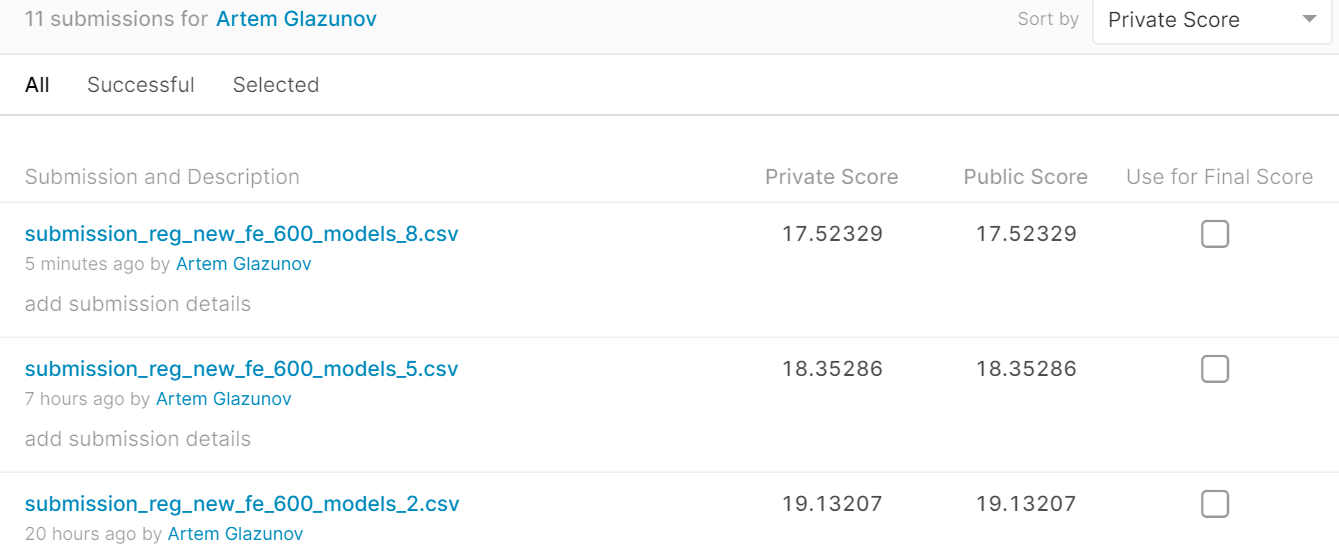

Видно, что по результатм множества попыток удалось получить скорр выше предыдущей недели при обучении на 6 месяцах.

Добавим еще признаков и проверим в соревновании.


In [33]:
for number in range(6):
  datasets_new[number]['is_tue_morning'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 1)&(x.hour in range(6,12))))
  datasets_new[number]['is_tue_evening'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 1)&(x.hour in range(18,24))))

  datasets_new[number]['is_wed_morning'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 2)&(x.hour in range(6,12))))
  datasets_new[number]['is_wed_evening'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 2)&(x.hour in range(18,24))))

  datasets_new[number]['is_th_morning'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 3)&(x.hour in range(6,12))))
  datasets_new[number]['is_th_evening'] = datasets_new[number]['datetime'].apply(lambda x: int((x.weekday() == 3)&(x.hour in range(18,24))))

  datasets_new[number]['is_month_beg'] = datasets_new[number]['day_of_month'].apply(lambda x: int(x in range(1,10)))
  datasets_new[number]['is_month_mid'] = datasets_new[number]['day_of_month'].apply(lambda x: int(x in range(10,20)))
  datasets_new[number]['is_month_end'] = datasets_new[number]['day_of_month'].apply(lambda x: int(x in range(20,31)))

datasets_new[0].head()

,hour_counter,year,month,month_name,day_of_year,day_of_month,day_of_week,day_name,day_hour,zone_id,datetime,history_12,history_24,history_168,history_720,ts,srmx_forecast,target,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,is_holiday,is_weekend,is_night,is_morning,is_afternoon,is_evening,is_center,is_broadway,is_airport,zone_center_product,neibour_zones_count_10_h,neibour_zones_count_1_h,added_areg_fe_day_1,added_areg_fe_week_1,1_hours_forecast,is_sun_morning,is_sun_afternoon,is_sun_evening,is_sat_morning,is_sat_afternoon,is_sat_evening,is_fr_evening,is_mon_morning,is_tue_morning,is_tue_evening,is_wed_morning,is_wed_evening,is_th_morning,is_th_evening,is_month_beg,is_month_mid,is_month_end
0,1,2015,12,December,335,1,1,Tuesday,0,1075,2015-12-01 00:00:00,1031.269231,1385.807692,10552.346154,43939.576923,19,56.797194,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352865,0,0,1,0,0,0,0,0,0,-1.272641,0.0,210,-1.0,-1.0,9.446603,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,2015,12,December,335,1,1,Tuesday,1,1075,2015-12-01 01:00:00,967.538462,1382.846154,10543.153846,43900.000000,16,57.155572,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623071,0,0,1,0,0,0,0,0,0,-1.272641,0.0,122,-1.0,-1.0,7.852633,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,2015,12,December,335,1,1,Tuesday,2,1075,2015-12-01 02:00:00,887.346154,1379.730769,10535.269231,43872.423077,8,57.516078,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.797509,0,0,1,0,0,0,0,0,0,-1.272641,0.0,49,-1.0,-1.0,4.299701,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,2015,12,December,335,1,1,Tuesday,3,1075,2015-12-01 03:00:00,792.615385,1379.153846,10531.961538,43854.961538,3,57.879168,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.878254,0,0,1,0,0,0,0,0,0,-1.272641,0.0,36,-1.0,-1.0,3.014358,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,5,2015,12,December,335,1,1,Tuesday,4,1075,2015-12-01 04:00:00,699.884615,1379.884615,10532.576923,43844.884615,2,58.244975,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.891039,0,0,1,0,0,0,0,0,0,-1.272641,0.0,40,-1.0,-1.0,11.664944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [34]:
train_lims = ['2015-12-01 00:00:00','2016-05-30 23:00:00']

ans_may_list = []
ans_june_list = []
for zone in tqdm_notebook(zones):
  print(zone)
  models = []
  data_may_list = []
  data_june_list = []

  for count in tqdm_notebook(range(6)):
    dataset = datasets_new[count]
    dataset_zone = dataset[dataset.zone_id == zone]
    dataset_zone.index = list(range(dataset_zone.shape[0]))
    params_prep = params_list[count]
    cols_to_mix = cols_to_mix_list[count]
    cols_to_drop = cols_to_drop_list[count]
    regressor = regressor_list[count]

    model,data_may,data_june = model_and_data_prep(dataset_zone,params_prep,cols_to_mix,cols_to_drop,
                                                   regressor,train_lims)

    models.append(model)
    data_may_list.append(data_may)
    data_june_list.append(data_june)



  prediction_may = pd.DataFrame()
  for (ind,(data,model)) in enumerate(zip(data_may_list,models)):
    prediction  = model.predict(data.drop(columns=['target']).values)
    prediction_may[f'{ind+1}_hours_forecast'] = prediction

  prediction_may['datetime'] = data_may.datetime.values

  ans_may_list.append(create_submission_zone(prediction_may))

  prediction_june = pd.DataFrame()
  for (ind,(data,model)) in enumerate(zip(data_june_list,models)):
    prediction  = model.predict(data.drop(columns=['target']).values)
    prediction_june[f'{ind+1}_hours_forecast'] = prediction

  prediction_june['datetime'] = data_june.datetime.values

  ans_june_list.append(create_submission_zone(prediction_june))


ans_may = pd.concat(ans_may_list)
ans_june = pd.concat(ans_june_list) 

1075



1076



1077



1125



1126



1127



1128



1129



1130



1131



1132



1172



1173



1174



1175



1176



1177



1178



1179



1180



1181



1182



1183



1184



1221



1222



1223



1224



1225



1227



1228



1229



1230



1231



1232



1233



1234



1235



1272



1273



1274



1278



1279



1280



1281



1282



1283



1284



1285



1286



1287



1326



1327



1331



1332



1333



1334



1335



1336



1337



1338



1339



1376



1377



1378



1380



1382



1383



1384



1385



1386



1387



1388



1389



1390



1426



1431



1434



1435



1436



1437



1438



1439



1441



1442



1480



1482



1483



1530



1532



1533



1580



1630



1684



1733



1734



1783



2068



2069



2118



2119



2168


In [35]:
ans_june.to_csv('submission_reg_new_fe_600_models_9.csv',index_label='id')

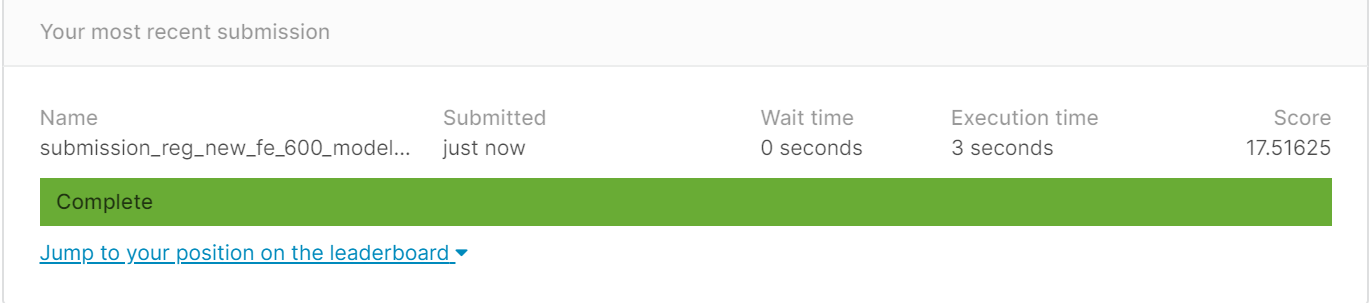

Видно совсем слабое улучшение в качестве. Теперь загрузим все ответы и усредним. Таким образом, получится финальный ответ.

In [37]:
sub_names = ['submission','submission_reg_1','submission_reg_2','submission_reg_new_fe_1','submission_reg_new_fe_600_models',
             'submission_reg_new_fe_600_models_2','submission_reg_new_fe_600_models_3','submission_reg_new_fe_600_models_4',
             'submission_reg_new_fe_600_models_5','submission_reg_new_fe_600_models_6','submission_reg_new_fe_600_models_7',
             'submission_reg_new_fe_600_models_8','submission_reg_new_fe_600_models_9']
submission_list = []
for submission_name in sub_names:
  sub = pd.read_csv(os.path.join(PATH_TO_DATA ,f'{submission_name}.csv'),index_col=0)
  submission_list.append(sub) 
sub_df = pd.concat(submission_list,axis=1)
sub_df.head()

,y,y,y,y,y,y,y,y,y,y,y,y,y
id,,,,,,,,,,,,,
1075_2016-05-31_23_1,25.602848,16.399832,18.833048,19.716469,19.321819,23.460798,22.686118,30.286367,25.263065,21.851088,30.187618,28.835823,30.584465
1075_2016-05-31_23_2,11.528346,8.225477,14.757373,15.491586,15.047598,17.509535,14.419610,22.058500,21.828342,16.052608,17.904415,10.671903,15.453918
1075_2016-05-31_23_3,5.106288,5.671033,7.966587,24.285340,2.018510,4.520046,4.951888,6.311708,10.251502,5.085135,3.988132,6.820164,5.811069
1075_2016-05-31_23_4,3.770281,1.575185,7.308908,4.664234,1.324823,5.027354,5.889674,5.205108,3.597452,4.287152,3.119378,4.133295,3.341412
1075_2016-05-31_23_5,7.673063,4.855235,0.910218,10.054827,6.024157,4.516340,6.998952,7.358109,5.972786,0.392009,5.167752,5.133339,3.301719


In [40]:
sub_df['mean'] = sub_df.mean(axis=1)
sub_df.head()

,y,y,y,y,y,y,y,y,y,y,y,y,y,mean
id,,,,,,,,,,,,,,
1075_2016-05-31_23_1,25.602848,16.399832,18.833048,19.716469,19.321819,23.460798,22.686118,30.286367,25.263065,21.851088,30.187618,28.835823,30.584465,24.079181
1075_2016-05-31_23_2,11.528346,8.225477,14.757373,15.491586,15.047598,17.509535,14.419610,22.058500,21.828342,16.052608,17.904415,10.671903,15.453918,15.457632
1075_2016-05-31_23_3,5.106288,5.671033,7.966587,24.285340,2.018510,4.520046,4.951888,6.311708,10.251502,5.085135,3.988132,6.820164,5.811069,7.137492
1075_2016-05-31_23_4,3.770281,1.575185,7.308908,4.664234,1.324823,5.027354,5.889674,5.205108,3.597452,4.287152,3.119378,4.133295,3.341412,4.095712
1075_2016-05-31_23_5,7.673063,4.855235,0.910218,10.054827,6.024157,4.516340,6.998952,7.358109,5.972786,0.392009,5.167752,5.133339,3.301719,5.258347


In [42]:
sub_final = sub_df[['mean']].copy()
sub_final.columns = ['y']
sub_final.to_csv('submission_final.csv',index_label='id')

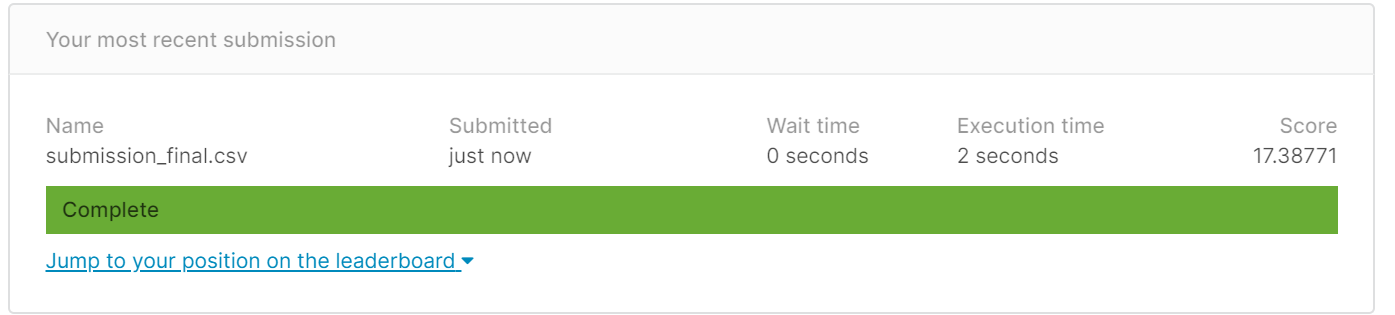

Усреднением удалось добиться лучшего качества. Данный скорр входит примерно в 40% лучших в соревновании, исходя из лидерборда. При этом обучение проходило лишь на 6 месяцах. Очевидно, что при использовании данных моделей и большего количества данных, в особенности, сведений по июням предыдущих лет, данный скорр может быть существенно улучшен.

Таким образом, построение 600 моделей, подготовка множества разных решений и последующее усреднение ответов дало улучшение по сравнению с предыдущими неделями.